In [186]:
import tensorflow as tf
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

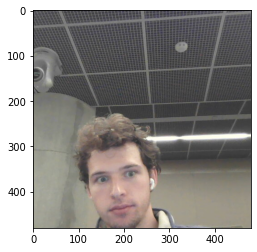

In [187]:
# LOAD IMAGE
img = Image.open('data/myface.jpg')
image = np.asarray(img)
original_h = image.shape[0]
original_w = image.shape[1]
image = image[:,int((original_w/2)-(original_h/2)):int((original_w/2)+(original_h/2)),:]
plt.imshow(image)

In [188]:
# MEDIAPIPE FACE DETECT INTERPRETER
interpreter = tf.lite.Interpreter(model_path="face_detection_short_range.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


In [189]:
def _ssd_generate_anchors() -> np.ndarray:
    """
    (reference: mediapipe/calculators/tflite/ssd_anchors_calculator.cc)
    """
    layer_id = 0
    num_layers = 4
    strides = [8, 16, 16, 16]
    assert len(strides) == num_layers
    input_height = 128
    input_width = 128
    anchor_offset_x = 0.5
    anchor_offset_y = 0.5
    interpolated_scale_aspect_ratio = 1
    anchors = []
    while layer_id < num_layers:
        last_same_stride_layer = layer_id
        repeats = 0
        while (last_same_stride_layer < num_layers and
               strides[last_same_stride_layer] == strides[layer_id]):
            last_same_stride_layer += 1
            # aspect_ratios are added twice per iteration
            repeats += 2 if interpolated_scale_aspect_ratio == 1.0 else 1
        stride = strides[layer_id]
        feature_map_height = input_height // stride
        feature_map_width = input_width // stride
        for y in range(feature_map_height):
            y_center = (y + anchor_offset_y) / feature_map_height
            for x in range(feature_map_width):
                x_center = (x + anchor_offset_x) / feature_map_width
                for _ in range(repeats):
                    anchors.append((x_center, y_center))
        layer_id = last_same_stride_layer
    return np.array(anchors, dtype=np.float32)
anchors = _ssd_generate_anchors()
with open("anchors.txt", 'w') as f:
    for i in range(anchors.shape[0]):
        if i % 8 == 0:
            f.write('\n')
        f.write(f'{anchors[i,0]:.5f},{anchors[i,1]:.5f},')
        

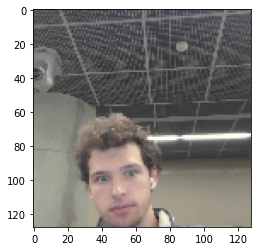

In [190]:
# FORMAT INPUT IMAGE
original_size = image.shape[0]
size = 128
resized_image = np.zeros([1,128,128,3],dtype='float32')
for x in range(0, size):  
    for y in range(0, size):
        srcX = int(round(float(x)/float(size)*float(original_size)))
        srcY = int(round(float(y)/float(size)*float(original_size)))
        srcX = min(srcX,original_size-1)
        srcY = min(srcY,original_size-1)
        pixel = image[srcX, srcY, :]
        resized_image[0,x,y,:] = pixel / 255
plt.imshow(np.reshape(resized_image, [128,128,3]))

In [191]:
# RUN FACE DETECT MODEL
interpreter.set_tensor(input_details[0]['index'], resized_image)
interpreter.invoke()
raw_boxes = interpreter.get_tensor(interpreter.get_output_details()[0]['index'])
raw_scores = interpreter.get_tensor(interpreter.get_output_details()[1]['index'])

In [192]:
# GET HIGHEST SCORE
raw_scores[raw_scores < -80] = -80
raw_scores[raw_scores > 80] = 80
best_index = 0
best_score = 0
for i in range(896):
    score = 1.0 / (1.0 + np.exp(-raw_scores[0,i,0]))
    if score > best_score:
        best_score = score
        best_index = i

In [193]:
# DECODE BOX
scale = 128
num_points = 8
# scale all values (applies to positions, width, and height alike)
face_box_center = raw_boxes[0, best_index, 0:2] / scale
face_box_wh = raw_boxes[0, best_index, 2:4] / scale
# adjust center coordinates to anchor positions
face_box_center += anchors[best_index]
# convert x_center, y_center, w, h to xmin, ymin, xmax, ymax
center = np.array(face_box_center)
half_size = face_box_wh / 2
[xmin, ymin] = center - half_size
[xmax, ymax] = center + half_size

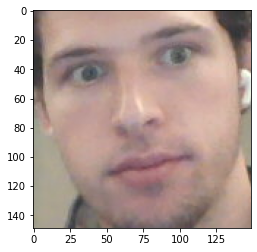

In [194]:
# EXTRACT FACE
face = image[int(ymin*original_size):int(ymax*original_size), int(xmin*original_size):int(xmax*original_size),:]
plt.imshow(face)

In [195]:
# MOBILENET INTERPRETER
interpreter = tf.lite.Interpreter(model_path="mobilenet_v1_0.25_192_quant.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

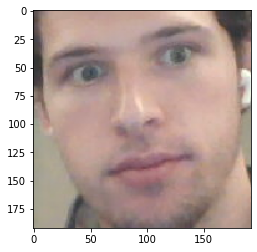

In [196]:
# FORMAT INPUT IMAGE
original_size = face.shape[0]
size = 192
resized_face = np.zeros([1,192,192,3],dtype='float32')
for x in range(0, size):  
    for y in range(0, size):
        srcX = int(round(float(x)/float(size)*float(original_size)))
        srcY = int(round(float(y)/float(size)*float(original_size)))
        srcX = min(srcX,original_size-1)
        srcY = min(srcY,original_size-1)
        pixel = face[srcX, srcY, :]
        resized_face[0,x,y,:] = pixel
plt.imshow(np.reshape(resized_face/255, [192,192,3]))
resized_face_uint8 = resized_face.astype('uint8')

In [197]:
# RUN MOBILENET MODEL
interpreter.set_tensor(input_details[0]['index'], resized_face_uint8)
interpreter.invoke()
logits = interpreter.get_tensor(output_details[0]['index'])
print(logits[logits != 0])
print(type(logits[0,0]))

[ 4  1  4  7  6  1  2  1 26  1  3  5  1  3  2  1  6  1  1  1 61  3 13  1
  6 30  2  1  2  1  6  2  1  9  1  1  2  1  1  1 20  1  1]
<class 'numpy.uint8'>
